In [ ]:
# uq360 version 0.2 needs to be installed
!pip install uq360

In [1]:
try:
    from uq360.metrics import picp, mpiw, compute_regression_metrics
    from uq360.metrics import UncertaintyCharacteristicsCurve as ucc

    from uq360.algorithms import * 
    from uq360.algorithms.actively_learned_model import ActivelyLearnedModel
    from uq360.algorithms.ensemble_heteroscedastic_regression import EnsembleHeteroscedasticRegression

    import pandas as pd
    import numpy as np
    import torch

    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    print('All the libraries are found')
    
except:
    print("One or more libraries need to be installed")

All the libraries are found


In [2]:
def read_data(file_name,sheet_name):
    
    xls_new = pd.ExcelFile(file_name)
    df=pd.read_excel(xls_new,sheet_name,header=1).dropna(how='all', axis=1)
    df.drop('#',axis=1,inplace=True)
    
    return df

data = read_data(r'/data/MGP/TestPoints_100k_NEW.xlsx','ResFeasible')

In [3]:
#Kanika
data

,Liquid density [kg/m3],Liquid \nviscosity\n [Pa.s],Gas molar mass \n[g/mol],Gas inlet compressibility\n,Hub radius [m],Tip radius [m],Stage 1 [y=1/n=0],Tin [K],Pin [kPa],GVFin,...,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61
0,989.321765,0.000558,28.013,0.999146,0.14,0.16,1,322.017877,1867.320507,45.802559,...,0.511641,0.481170,0.282785,44.199004,0.100509,1.534924,38.493574,0.090901,-82.805027,-82.510976
1,997.303292,0.000839,28.013,0.996045,0.14,0.16,1,300.789449,2261.871734,23.139203,...,0.101193,0.215564,0.072913,18.578440,0.054718,0.303578,17.245107,0.053124,-95.641822,-94.785923
2,992.909998,0.000611,28.013,1.001839,0.14,0.16,1,316.852547,5056.459294,46.289280,...,0.160709,0.536857,0.188671,44.027960,0.075112,0.482127,42.948563,0.073961,-91.866904,-91.822715
3,979.249421,0.000400,28.013,1.006971,0.14,0.16,1,344.056608,4641.124807,50.149929,...,0.116026,0.621454,0.492915,50.014722,0.130476,0.348078,49.716317,0.128725,-81.856351,-81.617170
4,991.458984,0.000593,28.013,0.999425,0.14,0.16,1,318.474477,3259.999596,40.705742,...,0.512668,0.456966,0.265734,41.638716,0.095642,1.538003,36.557283,0.087832,-83.343677,-83.547905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61220,993.307603,0.000659,28.013,0.997979,0.14,0.16,1,312.675702,2168.269984,73.980593,...,0.580630,0.877313,0.422514,73.258925,0.128289,1.741889,70.185019,0.116052,-75.168011,-74.742154
61221,979.013643,0.000404,28.013,1.003220,0.14,0.16,1,343.324449,3142.194751,23.701937,...,0.483268,0.243125,0.281590,23.139584,0.095482,1.449804,19.450000,0.090686,-84.072124,-83.439957
61222,976.836571,0.000381,28.013,1.005500,0.14,0.16,1,347.624602,3880.621826,28.295631,...,0.214003,0.320294,0.134274,27.408280,0.065917,0.642008,25.623543,0.064169,-92.708562,-92.300374
61223,988.950121,0.000551,28.013,0.999209,0.14,0.16,1,322.756787,1772.036814,55.869969,...,0.173825,0.676903,0.460372,56.380953,0.128793,0.521475,54.152261,0.122867,-81.158805,-81.033007


In [3]:
def select_columns(df,columns,input_columns,output_columns):
    
    df = df[columns]
    df['Diff_Pressure'] = df['Pout [kPA]'] - df['Pin [kPa]']
    df = pd.concat([df[input_columns],df[output_columns]],axis=1)
    
    return df

In [4]:
columns = ['Tin [K]','Pin [kPa]','N [rpm]','Total Consumed power','Pout [kPA]','GVFin','Qin [m3/s]']
INPUT_C = ['Tin [K]','Pin [kPa]','N [rpm]','Total Consumed power','Pout [kPA]']
OUTPUT_C =['Qin [m3/s]']
data_1 = select_columns(data,columns,INPUT_C,OUTPUT_C)

/tmp/ipykernel_47956/4194695666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Diff_Pressure'] = df['Pout [kPA]'] - df['Pin [kPa]']


In [5]:
# no need -of this cell, I am checking for the correct shape
data_1.shape

(61225, 6)

## Part 1- Implementing Active Learning

In [6]:
# scale the data and select the number of samples to be considered
def scale_data(df,samples):
    df_1 = df[0:samples]
    df_x = df_1.iloc[:, :-1].values
    y_labels = np.squeeze(df_1.iloc[:, -1:].values, axis=1)
    y_labels = y_labels.reshape((-1,1))

    # scale the values
    scaler = StandardScaler()
    scaling = scaler.fit(df_x)
    x_data = scaling.transform(df_x)
    
    
    return df, y_labels, x_data

data,y_labels,x_data = scale_data(data_1,30000)

In [7]:
''' 
    Offline sample and query, two mandatory arguments (and the data):
    - Position where to start sampling
    - Number of points to sample
'''
def sample_(start_index, n_points, X_data=x_data):
    return x_data[start_index:start_index+n_points,:]

def querry_(start_index, n_points, y_labels=y_labels):
    return y_labels[start_index:start_index+n_points]


In [8]:
# define configuration for both models, regression baseline and regression with Active Learning
def config_():
    device = torch.device("cpu")

    # define config for Heteroscedastic regression
    config_HR = {"num_features": 5, "num_hidden": 32, "num_outputs": 1, "batch_size": 16, "num_epochs": 10,
                      "lr": 0.001}
    HR_kwargs = {"model_type":'mlp',
                   "config": config_HR,
                   "device": device}
    # define config for ensemble
    config_ensemble = {"num_models": 1, 
              "batch_size": 16,
              "model_kwargs":HR_kwargs, }

    ninit = 128
    T = 4 # do not change this, since the model is CPU based  T 25 gives error need atleast one array
    # define config for active learning object
    # T = # no of iterations
    # K = # no of uncertain points
    config_AL = {"num_init": 512, 
     "T": 4, 
     "K": 64, 
     "M": 4, 
     "sampling_function": sample_, 
     "querry_function" : querry_,
     "model_function": EnsembleHeteroscedasticRegression,
     "model_kwargs": {"model_type":'ensembleheteroscedasticregression', 
                                                 "config":config_ensemble, 
                                                 "device":device}, }
    
    return config_HR,HR_kwargs,config_AL
config_HR,HR_kwargs,config_AL = config_()

In [9]:
# Verify that the data set has the good dimension
def verify_dimension(data_x,config_AL,config_HR):
    
    assert(data_x.shape[0] >= config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"])
    assert(data_x.shape[1] == config_HR["num_features"])
    
    return True

verify_dimension(x_data,config_AL,config_HR)

True

In [10]:
def baseline(config_AL):
    # Baseline without AL
    K_train_list = [16, 32, 64, 128, 256, 512]
    frac_err_baseline = []
    ninit=128
    N_test = 512
    device = torch.device("cpu")
    T=4
    for i in range(len(K_train_list)):

        # Update dictiorary to have no active learning and the correct amount of points
        config_AL["model_kwargs"]["config"]["num_models"] = 5
        config_AL["num_init"] = ninit + K_train_list[i] * T
        print(config_AL["num_init"])
        config_AL["T"] = 0  # no AL here

        # Instantiate the class object and train the model
        uq_model = ActivelyLearnedModel(config=config_AL, device=device, online=False)
        uq_model = uq_model.fit() # until here it is working # model loss -training

        # Create a test dataset
        X_test = sample_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
        y_test = querry_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
        y_test = np.reshape(y_test, (-1,))
        print(X_test.shape,y_test.shape)

        res = uq_model.predict(X_test) 
        print(X_test.shape)
        y_test_pred = np.squeeze(res.y_mean, axis=1)

        frac_err_baseline.append(np.sqrt(np.sum(np.square(y_test - y_test_pred)))/np.sqrt(np.sum(np.square(y_test))))
        print('iteration---------',i)
        
    return  frac_err_baseline

In [11]:
errors_baseline=baseline(config_AL)

192

Training model 0

Epoch: 0, loss = 0.6799914290507635
Epoch: 1, loss = 0.5952014277378719
Epoch: 2, loss = 0.5211907799045246
Epoch: 3, loss = 0.44937964280446363
Epoch: 4, loss = 0.37528171390295034
Epoch: 5, loss = 0.2961791219810645
Epoch: 6, loss = 0.20944171771407127
Epoch: 7, loss = 0.11386424489319326
Epoch: 8, loss = 0.008518327027559279
Epoch: 9, loss = -0.10694995646675426

Training model 1

Epoch: 0, loss = 0.7059683998425801
Epoch: 1, loss = 0.6409183293581008
Epoch: 2, loss = 0.577372873822848
Epoch: 3, loss = 0.5116916944583257
Epoch: 4, loss = 0.44103494534889864
Epoch: 5, loss = 0.36316909144322074
Epoch: 6, loss = 0.27646369362870854
Epoch: 7, loss = 0.17947303193310896
Epoch: 8, loss = 0.07077185173208515
Epoch: 9, loss = -0.05080209206789732

Training model 2

Epoch: 0, loss = 0.7265736311674118
Epoch: 1, loss = 0.6318246573209763
Epoch: 2, loss = 0.554073433081309
Epoch: 3, loss = 0.48047244797150296
Epoch: 4, loss = 0.40385369956493383
Epoch: 5, loss = 0.32280

Epoch: 9, loss = -1.9439502341879742

Training model 1

Epoch: 0, loss = 0.5815198603603575
Epoch: 1, loss = 0.049515883140783326
Epoch: 2, loss = -0.7829138504134285
Epoch: 3, loss = -1.3678697993357976
Epoch: 4, loss = -1.5978513575262496
Epoch: 5, loss = -1.71097288115157
Epoch: 6, loss = -1.8361309832996786
Epoch: 7, loss = -1.8812179780668676
Epoch: 8, loss = -1.966198159588708
Epoch: 9, loss = -2.0056112358967466

Training model 2

Epoch: 0, loss = 0.6776625319487519
Epoch: 1, loss = 0.22468310585504184
Epoch: 2, loss = -0.5152211630096036
Epoch: 3, loss = -1.0137931431333222
Epoch: 4, loss = -1.4121904282106292
Epoch: 5, loss = -1.5244201281004484
Epoch: 6, loss = -1.712517289651764
Epoch: 7, loss = -1.7191638648509977
Epoch: 8, loss = -1.877744265728527
Epoch: 9, loss = -1.924430607093705

Training model 3

Epoch: 0, loss = 0.5690964398284755
Epoch: 1, loss = 0.08228557062749232
Epoch: 2, loss = -0.47031731779376656
Epoch: 3, loss = -1.01199938936366
Epoch: 4, loss = -1.3502518

In [12]:
def with_al(config_AL):
    # AL, ensemble of 5 NNs
    frac_err_AL_ens = []
    device = torch.device("cpu")
    K_train_list = [16, 32, 64, 128, 256, 512] # make it as a global variable
    N_test = 512
    ninit=128
    T=4
    for i in range(len(K_train_list)):

        # Update dictiorary for the correct amount of points
        config_AL["model_kwargs"]["config"]["num_models"] = 5
        config_AL["num_init"] = ninit
        config_AL["K"] = K_train_list[i]
        config_AL["M"] = 4
        config_AL["T"] = T

        # Instantiate the class object and train the model
        uq_model = ActivelyLearnedModel(config=config_AL, device=device, online=False)
        uq_model = uq_model.fit()

        
        # Create a test dataset
        X_test = sample_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
        y_test = querry_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
        y_test = np.reshape(y_test, (-1,))

        res = uq_model.predict(X_test)
        y_test_pred = np.squeeze(res.y_mean, axis=1)

        frac_err_AL_ens.append(np.sqrt(np.sum(np.square(y_test - y_test_pred)))/np.sqrt(np.sum(np.square(y_test))))
        
    return frac_err_AL_ens


In [13]:
errors_al = with_al(config_AL)


Training model 0

Epoch: 0, loss = 0.8344416245818138
Epoch: 1, loss = 0.7974907830357552
Epoch: 2, loss = 0.7642046883702278
Epoch: 3, loss = 0.7311419323086739
Epoch: 4, loss = 0.6972347423434258
Epoch: 5, loss = 0.6621711403131485
Epoch: 6, loss = 0.6250587925314903
Epoch: 7, loss = 0.5853038504719734
Epoch: 8, loss = 0.5423849634826183
Epoch: 9, loss = 0.4958737939596176

Training model 1

Epoch: 0, loss = 0.7736414968967438
Epoch: 1, loss = 0.7150424495339394
Epoch: 2, loss = 0.6651066765189171
Epoch: 3, loss = 0.6177576035261154
Epoch: 4, loss = 0.5691270306706429
Epoch: 5, loss = 0.5189583599567413
Epoch: 6, loss = 0.4671752266585827
Epoch: 7, loss = 0.41288335993885994
Epoch: 8, loss = 0.355633269995451
Epoch: 9, loss = 0.29482607915997505

Training model 2

Epoch: 0, loss = 0.807803139090538
Epoch: 1, loss = 0.7767249867320061
Epoch: 2, loss = 0.7454440221190453
Epoch: 3, loss = 0.7131995260715485
Epoch: 4, loss = 0.6794783547520638
Epoch: 5, loss = 0.6438019871711731
Epoch: 

Epoch: 2, loss = -1.9850128094355262
Epoch: 3, loss = -1.873079111178716
Epoch: 4, loss = -1.7555571496486662
Epoch: 5, loss = -1.8931968907515209
Epoch: 6, loss = -1.7636443972587585
Epoch: 7, loss = -1.9556300938129425
Epoch: 8, loss = -2.0335583190123243
Epoch: 9, loss = -2.0741897920767465

Training model 2

Epoch: 0, loss = -1.5284046580394108
Epoch: 1, loss = -1.5735684235890708
Epoch: 2, loss = -1.6747030913829803
Epoch: 3, loss = -1.7406587203343706
Epoch: 4, loss = -1.7622078160444894
Epoch: 5, loss = -1.6771304706732433
Epoch: 6, loss = -1.442042628924052
Epoch: 7, loss = -1.658596048752467
Epoch: 8, loss = -1.492231920361519
Epoch: 9, loss = -1.5455191632111869

Training model 3

Epoch: 0, loss = -1.4070620338122048
Epoch: 1, loss = -1.430319428443909
Epoch: 2, loss = -1.1363088823854923
Epoch: 3, loss = -1.2790035754442215
Epoch: 4, loss = -1.2426727364460628
Epoch: 5, loss = -1.291507214307785
Epoch: 6, loss = -1.3437020778656004
Epoch: 7, loss = -1.4412337442239125
Epoch:

Epoch: 7, loss = -1.4184070101806094
Epoch: 8, loss = -1.5552849641868047
Epoch: 9, loss = -1.6096841182027544

Training model 3

Epoch: 0, loss = -1.162535126720156
Epoch: 1, loss = -1.1831775094781602
Epoch: 2, loss = -0.9968368953892164
Epoch: 3, loss = -1.1602550787585122
Epoch: 4, loss = -1.1248057442052024
Epoch: 5, loss = -1.0868415385484695
Epoch: 6, loss = -0.9664363318255971
Epoch: 7, loss = -0.884533915668726
Epoch: 8, loss = -0.9769095416579928
Epoch: 9, loss = -1.187931788819177

Training model 4

Epoch: 0, loss = -1.2292569449969701
Epoch: 1, loss = -1.286460480519703
Epoch: 2, loss = -1.3959426539284843
Epoch: 3, loss = -1.4135487845965793
Epoch: 4, loss = -1.4676006393773215
Epoch: 5, loss = -1.598349119935717
Epoch: 6, loss = -1.6422760997499737
Epoch: 7, loss = -1.4183746576309204
Epoch: 8, loss = -1.4525883623531888
Epoch: 9, loss = -1.5399196233068195

T = 3


Training model 0

Epoch: 0, loss = -1.4447544813156128
Epoch: 1, loss = -1.2561657801270485
Epoch: 2, loss 

Epoch: 3, loss = -0.771494809538126
Epoch: 4, loss = -0.8714142180979252
Epoch: 5, loss = -1.0107361860573292
Epoch: 6, loss = -1.132780596613884
Epoch: 7, loss = -1.1797550208866596
Epoch: 8, loss = -1.1114021483808756
Epoch: 9, loss = -1.3178188726305962

T = 2


Training model 0

Epoch: 0, loss = -0.9305411338806154
Epoch: 1, loss = -1.0731848239898683
Epoch: 2, loss = -1.030782473087311
Epoch: 3, loss = -0.8925433039665222
Epoch: 4, loss = -0.6699833586812018
Epoch: 5, loss = -0.8653724387288092
Epoch: 6, loss = -1.1498486965894699
Epoch: 7, loss = -1.3047108709812165
Epoch: 8, loss = -1.4053036779165269
Epoch: 9, loss = -1.4525061130523682

Training model 1

Epoch: 0, loss = -1.0129454553127288
Epoch: 1, loss = -1.0368398606777192
Epoch: 2, loss = -0.9686664156615733
Epoch: 3, loss = -0.881257450580597
Epoch: 4, loss = -1.085236692428589
Epoch: 5, loss = -1.2992586731910707
Epoch: 6, loss = -1.4568484544754028
Epoch: 7, loss = -1.4872993767261506
Epoch: 8, loss = -1.51996929645538

Epoch: 7, loss = -0.8963977533082167
Epoch: 8, loss = -0.9668750700851281
Epoch: 9, loss = -0.9999107358356318

Training model 1

Epoch: 0, loss = -1.0028755764166513
Epoch: 1, loss = -0.6183266515533129
Epoch: 2, loss = -0.10219528774420401
Epoch: 3, loss = 0.1695281453430653
Epoch: 4, loss = -0.7605884581183395
Epoch: 5, loss = -0.9378410850962005
Epoch: 6, loss = -1.0636304020881655
Epoch: 7, loss = -1.102520008881887
Epoch: 8, loss = -1.2082450116674104
Epoch: 9, loss = -1.214136891067028

Training model 2

Epoch: 0, loss = -0.6179264516880113
Epoch: 1, loss = -0.7918772250413894
Epoch: 2, loss = -0.9858254318435989
Epoch: 3, loss = -1.0753041754166286
Epoch: 4, loss = -1.1338684161504111
Epoch: 5, loss = -1.2445627823472023
Epoch: 6, loss = -1.3743029509981475
Epoch: 7, loss = -1.3504465545217195
Epoch: 8, loss = -1.2722436611851053
Epoch: 9, loss = -0.9412421273688475

Training model 3

Epoch: 0, loss = -0.5660104677081107
Epoch: 1, loss = -0.7271570855130753
Epoch: 2, loss = -0.

Epoch: 0, loss = 0.49649380395809817
Epoch: 1, loss = 0.39944239954153693
Epoch: 2, loss = 0.2793438217292229
Epoch: 3, loss = 0.1386466009231905
Epoch: 4, loss = -0.03352497869248811
Epoch: 5, loss = -0.24055820377543566
Epoch: 6, loss = -0.4797610351815819
Epoch: 7, loss = -0.7487969311575092
Epoch: 8, loss = -0.9961859633525213
Epoch: 9, loss = -0.9508015116055806

Training model 3

Epoch: 0, loss = 0.32371673732995987
Epoch: 1, loss = 0.1998005538868407
Epoch: 2, loss = 0.036350065415414676
Epoch: 3, loss = -0.1421635818357269
Epoch: 4, loss = -0.33868118096143
Epoch: 5, loss = -0.5480796371897061
Epoch: 6, loss = -0.7058981694281101
Epoch: 7, loss = -0.8557038530707359
Epoch: 8, loss = -0.9230166375637054
Epoch: 9, loss = -1.0303444787859917

Training model 4

Epoch: 0, loss = 0.392896756529808
Epoch: 1, loss = 0.28905452353258926
Epoch: 2, loss = 0.16791216070608547
Epoch: 3, loss = 0.021945316810160872
Epoch: 4, loss = -0.1527775649835045
Epoch: 5, loss = -0.35282933091123897
Ep

Epoch: 6, loss = 0.4680880345404148
Epoch: 7, loss = 0.4202974699437618
Epoch: 8, loss = 0.36940673366189003
Epoch: 9, loss = 0.3150567561388016

Training model 4

Epoch: 0, loss = 0.73338932543993
Epoch: 1, loss = 0.6987508237361908
Epoch: 2, loss = 0.6643062233924866
Epoch: 3, loss = 0.6292145848274231
Epoch: 4, loss = 0.5930988490581512
Epoch: 5, loss = 0.5556176230311394
Epoch: 6, loss = 0.5164519399404526
Epoch: 7, loss = 0.4752686806023121
Epoch: 8, loss = 0.4317913390696049
Epoch: 9, loss = 0.38566718250513077

T = 0


Training model 0

Epoch: 0, loss = 0.5206146620213986
Epoch: 1, loss = 0.3379261126741767
Epoch: 2, loss = 0.07400590016040952
Epoch: 3, loss = -0.30549905709922315
Epoch: 4, loss = -0.7933594092726709
Epoch: 5, loss = -1.2305168122053147
Epoch: 6, loss = -1.4105999082326892
Epoch: 7, loss = -1.4613378774374723
Epoch: 8, loss = -1.4742617130279538
Epoch: 9, loss = -1.5833266302943232

Training model 1

Epoch: 0, loss = 0.23289720639586453
Epoch: 1, loss = -0.05744

Epoch: 8, loss = -2.8342818573993798
Epoch: 9, loss = -2.8784192467437073


In [14]:
def compare_err_plot(frac_err_baseline,frac_err_AL_ens):
    
    K_train_list = [16, 32, 64, 128, 256, 512]  # make it global
    ninit =128
    T=4
    N_train_list = ninit + T * np.array(K_train_list)
    plt.style.use("classic")
    fig = plt.figure()
    plt.plot(N_train_list,frac_err_baseline, ".-", label="Baseline")
    plt.plot(N_train_list,frac_err_AL_ens, ".-", label="Active learning, ensemble")
    plt.ylabel('Fractional error on test set')
    plt.xlabel('Number of training points')
    plt.legend()
    plt.show()
    
    return 

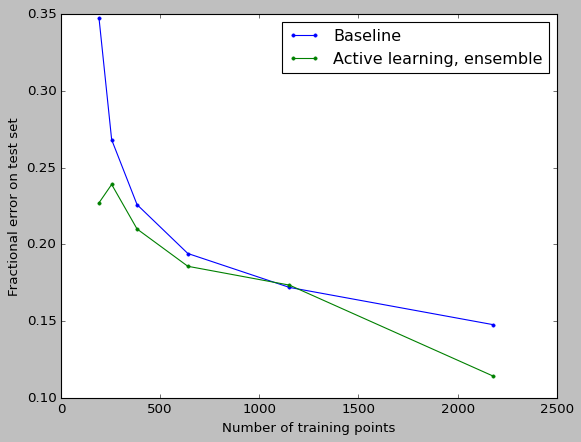

In [15]:
compare_err_plot(errors_baseline,errors_al)

## Part 2 save the weights to make predictions on the unseen data 

In [17]:
frac_err_AL_ens = []
device = torch.device("cpu")
K_train_list = [16, 32, 64, 128, 256, 512] # make it as a global variable
N_test = 512
ninit=128
T=4
for i in range(len(K_train_list)):

    # Update dictiorary for the correct amount of points
    config_AL["model_kwargs"]["config"]["num_models"] = 5
    config_AL["num_init"] = ninit
    config_AL["K"] = K_train_list[i]
    config_AL["M"] = 4
    config_AL["T"] = T

    # Instantiate the class object and train the model
    uq_model = ActivelyLearnedModel(config=config_AL, device=device, online=False)
    uq_model = uq_model.fit()
      



Training model 0

Epoch: 0, loss = 0.8344416245818138
Epoch: 1, loss = 0.7974907830357552
Epoch: 2, loss = 0.7642046883702278
Epoch: 3, loss = 0.7311419323086739
Epoch: 4, loss = 0.6972347423434258
Epoch: 5, loss = 0.6621711403131485
Epoch: 6, loss = 0.6250587925314903
Epoch: 7, loss = 0.5853038504719734
Epoch: 8, loss = 0.5423849634826183
Epoch: 9, loss = 0.4958737939596176

Training model 1

Epoch: 0, loss = 0.7736414968967438
Epoch: 1, loss = 0.7150424495339394
Epoch: 2, loss = 0.6651066765189171
Epoch: 3, loss = 0.6177576035261154
Epoch: 4, loss = 0.5691270306706429
Epoch: 5, loss = 0.5189583599567413
Epoch: 6, loss = 0.4671752266585827
Epoch: 7, loss = 0.41288335993885994
Epoch: 8, loss = 0.355633269995451
Epoch: 9, loss = 0.29482607915997505

Training model 2

Epoch: 0, loss = 0.807803139090538
Epoch: 1, loss = 0.7767249867320061
Epoch: 2, loss = 0.7454440221190453
Epoch: 3, loss = 0.7131995260715485
Epoch: 4, loss = 0.6794783547520638
Epoch: 5, loss = 0.6438019871711731
Epoch: 

Epoch: 7, loss = -1.9556300938129425
Epoch: 8, loss = -2.0335583190123243
Epoch: 9, loss = -2.0741897920767465

Training model 2

Epoch: 0, loss = -1.5284046580394108
Epoch: 1, loss = -1.5735684235890708
Epoch: 2, loss = -1.6747030913829803
Epoch: 3, loss = -1.7406587203343706
Epoch: 4, loss = -1.7622078160444894
Epoch: 5, loss = -1.6771304706732433
Epoch: 6, loss = -1.442042628924052
Epoch: 7, loss = -1.658596048752467
Epoch: 8, loss = -1.492231920361519
Epoch: 9, loss = -1.5455191632111869

Training model 3

Epoch: 0, loss = -1.4070620338122048
Epoch: 1, loss = -1.430319428443909
Epoch: 2, loss = -1.1363088823854923
Epoch: 3, loss = -1.2790035754442215
Epoch: 4, loss = -1.2426727364460628
Epoch: 5, loss = -1.291507214307785
Epoch: 6, loss = -1.3437020778656004
Epoch: 7, loss = -1.4412337442239125
Epoch: 8, loss = -1.5379763940970104
Epoch: 9, loss = -1.5942226747671762

Training model 4

Epoch: 0, loss = -1.7317940096060436
Epoch: 1, loss = -1.781889299551646
Epoch: 2, loss = -1.6429

Epoch: 9, loss = -0.9590060157435281

Training model 3

Epoch: 0, loss = -1.2287910495485581
Epoch: 1, loss = -1.1765170565673282
Epoch: 2, loss = -1.3779937922954562
Epoch: 3, loss = -1.439528001206262
Epoch: 4, loss = -1.4833287852151054
Epoch: 5, loss = -1.439815491437912
Epoch: 6, loss = -1.3306934578078133
Epoch: 7, loss = -1.5719641872814722
Epoch: 8, loss = -1.5220189435141427
Epoch: 9, loss = -1.5764223081724986

Training model 4

Epoch: 0, loss = -1.0739157455308095
Epoch: 1, loss = -1.1390717795916965
Epoch: 2, loss = -1.01841402053833
Epoch: 3, loss = -0.9547961354255675
Epoch: 4, loss = -0.8439610472747258
Epoch: 5, loss = -0.909392808164869
Epoch: 6, loss = -1.0909175404480524
Epoch: 7, loss = -1.2470534571579526
Epoch: 8, loss = -1.3429303424698968
Epoch: 9, loss = -1.4131459891796112

T = 3


Training model 0

Epoch: 0, loss = -1.6483953148126602
Epoch: 1, loss = -1.5139280706644058
Epoch: 2, loss = -1.2133687548339367
Epoch: 3, loss = -0.9372328603640199
Epoch: 4, loss 

Epoch: 6, loss = -1.0277909077703953
Epoch: 7, loss = -1.17489143460989
Epoch: 8, loss = -1.2651892229914665
Epoch: 9, loss = -1.1306459456682205

T = 2


Training model 0

Epoch: 0, loss = -1.3824535995721816
Epoch: 1, loss = -1.4374658942222598
Epoch: 2, loss = -1.4013781696558
Epoch: 3, loss = -1.2468035101890564
Epoch: 4, loss = -1.2934492096304895
Epoch: 5, loss = -1.324181067943573
Epoch: 6, loss = -1.2030240878462792
Epoch: 7, loss = -1.2787399649620055
Epoch: 8, loss = -1.2897857531905175
Epoch: 9, loss = -1.5590531706809991

Training model 1

Epoch: 0, loss = -1.1126955986022948
Epoch: 1, loss = -1.3025306165218358
Epoch: 2, loss = -1.2223327003419397
Epoch: 3, loss = -0.8883532613515854
Epoch: 4, loss = -0.857507289201021
Epoch: 5, loss = -0.8879190884530546
Epoch: 6, loss = -1.1764803677797318
Epoch: 7, loss = -1.2399712204933167
Epoch: 8, loss = -1.2769089877605437
Epoch: 9, loss = -1.264356079697609

Training model 2

Epoch: 0, loss = -1.0751167513430115
Epoch: 1, loss = -

Epoch: 0, loss = -0.9573244204123814
Epoch: 1, loss = -1.143225600322088
Epoch: 2, loss = -1.3332397093375523
Epoch: 3, loss = -1.4510455131530762
Epoch: 4, loss = -1.487467403213183
Epoch: 5, loss = -1.393613158414761
Epoch: 6, loss = -1.4019930437207222
Epoch: 7, loss = -1.5927585512399673
Epoch: 8, loss = -1.6713468035062153
Epoch: 9, loss = -1.710672025879224

Training model 2

Epoch: 0, loss = -0.6539924430350462
Epoch: 1, loss = -0.8498410234848658
Epoch: 2, loss = -1.0354849298795064
Epoch: 3, loss = -1.1439209828774135
Epoch: 4, loss = -1.2009235148628554
Epoch: 5, loss = -1.3330517013867698
Epoch: 6, loss = -1.3167670940359437
Epoch: 7, loss = -1.2919188936551411
Epoch: 8, loss = -1.3220697542031608
Epoch: 9, loss = -1.0713014230132105

Training model 3

Epoch: 0, loss = -0.8312343123058479
Epoch: 1, loss = -0.9987346852819123
Epoch: 2, loss = -1.114240137239297
Epoch: 3, loss = -1.2052483782172203
Epoch: 4, loss = -1.2478123630086577
Epoch: 5, loss = -1.2974353581666949
Epoch

Epoch: 9, loss = -1.261043931047122

Training model 3

Epoch: 0, loss = 0.345979101335009
Epoch: 1, loss = 0.23450352600775656
Epoch: 2, loss = 0.08806731753672163
Epoch: 3, loss = -0.059280517123018676
Epoch: 4, loss = -0.24318862314491219
Epoch: 5, loss = -0.42284535647680355
Epoch: 6, loss = -0.5786162006358306
Epoch: 7, loss = -0.7176971572140853
Epoch: 8, loss = -0.7196448702986041
Epoch: 9, loss = -0.6598308092604082

Training model 4

Epoch: 0, loss = 0.41342066476742434
Epoch: 1, loss = 0.3067093112816413
Epoch: 2, loss = 0.17681155571093166
Epoch: 3, loss = 0.021144522819668055
Epoch: 4, loss = -0.16924735265395915
Epoch: 5, loss = -0.3968609366565942
Epoch: 6, loss = -0.6469142735004426
Epoch: 7, loss = -0.856243619074424
Epoch: 8, loss = -0.9851627647876742
Epoch: 9, loss = -0.9894432413081329

T = 1


Training model 0

Epoch: 0, loss = -1.2056705817580222
Epoch: 1, loss = -0.9322294853627682
Epoch: 2, loss = -1.348079348355532
Epoch: 3, loss = -1.3187406815588478
Epoch: 4, 


Training model 0

Epoch: 0, loss = 0.44413199424743655
Epoch: 1, loss = 0.24771065185777844
Epoch: 2, loss = -0.033612817764515045
Epoch: 3, loss = -0.4322574097663165
Epoch: 4, loss = -0.9374657958745954
Epoch: 5, loss = -1.347611603140831
Epoch: 6, loss = -1.4589401572942737
Epoch: 7, loss = -1.5183967612683775
Epoch: 8, loss = -1.6118127509951596
Epoch: 9, loss = -1.6641302913427354

Training model 1

Epoch: 0, loss = 0.2759959906339645
Epoch: 1, loss = -0.008207638701424004
Epoch: 2, loss = -0.3941320285201073
Epoch: 3, loss = -0.8534154206514356
Epoch: 4, loss = -1.189074018597603
Epoch: 5, loss = -1.424460193514824
Epoch: 6, loss = -1.404942189902067
Epoch: 7, loss = -1.4508722729980947
Epoch: 8, loss = -1.6151409596204758
Epoch: 9, loss = -1.668490944802761

Training model 2

Epoch: 0, loss = 0.4758018508553505
Epoch: 1, loss = 0.30945291947573417
Epoch: 2, loss = 0.06741091043222695
Epoch: 3, loss = -0.2793239962309598
Epoch: 4, loss = -0.7475153177976609
Epoch: 5, loss = -1.0

In [18]:
# save the model
filepath='/workspace/malathi/mm/active_learning_weights.h5'
torch.save(uq_model,filepath)

# load the saved model
uq_model_loaded = torch.load('active_learning_weights.h5')

          
# Create a test dataset
X_test = sample_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
y_test = querry_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
y_test = np.reshape(y_test, (-1,))

res = uq_model_loaded.predict(X_test)
y_test_pred = np.squeeze(res.y_mean, axis=1)

frac_err_AL_ens.append(np.sqrt(np.sum(np.square(y_test - y_test_pred)))/np.sqrt(np.sum(np.square(y_test))))

# this error is the last one(best one) in the error_list if you see the below code
frac_err_AL_ens 

[0.11695072001951151]